# Machine Learning
***
## Digit Recognition

The objective of this project is to design and train a neural network to recognize hand-wriiten digits.

The MINST database has been used. A 2-layer neural network has been used.

### Step 0
***
Load the data and required modules.

In [1]:
import os
import struct
from array import array
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load(img_path , label_path) :

        with open(img_path , 'rb') as image_file:
            magic , size , rows , cols = struct.unpack('>IIII' , image_file.read(4*4))
            image_data = array('B' , image_file.read())

        img_size = rows*cols
        images = []

        for i in range(size) :
            image = image_data[i*img_size : (i+1)*img_size]
            images.append(image)

        with open(label_path , 'rb') as label_file :
            magic , size = struct.unpack('>II' , label_file.read(2*4))
            labels = array('B' , label_file.read())

        return images , labels

In [3]:
train_img_file = 'Loader/data/train-images-idx3-ubyte'
train_labels_file = 'Loader/data/train-labels-idx1-ubyte'

test_img_file = 'Loader/data/t10k-images-idx3-ubyte'
test_labels_file = 'Loader/data/t10k-labels-idx1-ubyte'

train_img , train_label = load(os.path.join( os.getcwd() ,train_img_file) , 
                                                                    os.path.join( os.getcwd() ,train_labels_file))
test_img , test_label = load(os.path.join( os.getcwd() ,test_img_file) , 
                                                                    os.path.join( os.getcwd() , test_labels_file))

In [4]:
X_train = np.array(train_img , dtype=np.float) / 255
y_train = np.array(train_label , dtype=np.int).reshape(1 , -1)

X_test = np.array(test_img , dtype=np.float) / 255
y_test = np.array(test_label , dtype=np.int).reshape(1 , -1)

X_train , X_test = X_train.T , X_test.T 

The data has normalized within the range [0 , 1].

In [5]:
n_x , m = X_train.shape
n_h = 10
n_o = y_train.shape[1]
img_h = int(math.sqrt(n_x))

print(f'Number of training examples = {m}')
print(f'Number of input units = {n_x}')
print(f'Number of hidden units = {n_h}')
print(f'Number of output units = {n_o}')
print(f'Image Height = {img_h}')

Number of training examples = 60000
Number of input units = 784
Number of hidden units = 10
Number of output units = 60000
Image Height = 28


### Step 1
***
Visualize the data

Text(0.5, 1.0, 'Digit = 3')

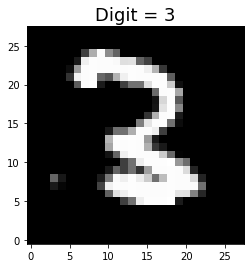

In [6]:
index = random.randint( 0 , n_x)

plt.imshow(X_train[ : , index].reshape(img_h , -1) , cmap = 'gray' , origin='lower')
plt.title(f'Digit = {y_train[0 , index]}' , fontsize='18')

### Step 2
***
Design and test the neural network architecture

In [7]:
def prep_labels(y , classes = 10) : #create the required dimensional output vector
    prep_y = np.zeros((classes , y.shape[1]))
    
    for i in range(classes) :
        prep_y[i , :] = (y==i).astype(np.int)
    
    return prep_y

In [8]:
def sigmoid(z) : #calculate sigmoid of z
    return 1 / (1 + np.exp(-z))

In [9]:
def initialize(n_x , n_h , n_o) : #randomly initialize the parameters
    W1 = np.random.randn(n_h , n_x) * 0.01
    b1 = np.zeros((n_h , 1))
    
    W2 = np.random.randn(n_o , n_h) * 0.01
    b2 = np.zeros((n_o , 1))
    
    params = {
        'W1' : W1 ,
        'b1' : b1 , 
        'W2' : W2 , 
        'b2' : b2 
    }
    
    return params

In [10]:
def forward_prop (X , params) : #forward propogation algorithm
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {
        'Z1' : Z1 ,
        'A1' : A1 ,
        'Z2' : Z2 ,
        'A2' : A2 
    }
    
    return cache

In [11]:
def compute_cost(X , y , cache) : #Compute the cost function
    Z1 = cache['Z1']
    A1 = cache['A1']
    Z2 = cache['Z2']
    A2 = cache['A2']
    
    loss = y * np.log(A2) + (1 - y) * np.log(1 - A2)
    cost = - np.sum(loss) / X.shape[1]
    
    return cost

In [12]:
def back_prop(X , y , cache , params) : #Backward propogation algorithm
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    Z1 = cache['Z1']
    A1 = cache['A1']
    Z2 = cache['Z2']
    A2 = cache['A2']
    
    dZ2 = A2 - y
    dW2 = np.dot(dZ2 , A1.T) / X.shape[1]
    db2 = np.mean(dZ2 , axis = 1 , keepdims = True)
    dZ1 = np.dot(W2.T , dZ2) * (1 - A1 ** 2)
    dW1 = np.dot(dZ1 , X.T) / X.shape[1]
    db1 = np.mean(dZ1 , axis = 1 , keepdims = True)
    
    grads = {
        'dW1' : dW1 ,
        'db1' : db1 ,
        'dW2' : dW2 ,
        'db2' : db2
    }
    
    return grads

In [18]:
def optimize(X , y , params , cache , iterations = 100 , learning_rate = 0.01) : # Batch Gradient Descent
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    costs = []
    
    for i in range(iterations) :
            
        grads = back_prop(X , y , cache , params)

        dW2 = grads['dW2']
        db2 = grads['db2']
        dW1 = grads['dW1']
        db1 = grads['db1']

        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2

        params = {
            'W1' : W1 ,
            'b1' : b1 , 
            'W2' : W2 , 
            'b2' : b2 
        }

        cache = forward_prop(X , params)

        if i % 10 == 0 :
            cost = compute_cost(X , y , cache)
            print(f'Cost at {i} iteration: {cost}')
            costs.append(cost)
                
    return params , costs
    

In [23]:
def nn_model(X , y , n_h , iterations = 2000 , classes = 10 , learning_rate = 0.1):
    y = prep_labels(y , classes)
    
    params = initialize(X.shape[0] , n_h , classes)
    
    cache = forward_prop(X , params)
    
    params , costs = optimize(X , y , params , cache , iterations , learning_rate)
    
    cache = forward_prop(X , params)
    
    model = {
        'params' : params , 
        'costs' : costs
    }
    
    return model

In [22]:
 model = nn_model(X_train , y_train , 500)

Cost at 0 iteration: 6.187577704942031
Cost at 10 iteration: 3.2442022292000563
Cost at 20 iteration: 3.080395987865751
Cost at 30 iteration: 2.8189038386066976
Cost at 40 iteration: 2.490971830712125
Cost at 50 iteration: 2.1905571272371915
Cost at 60 iteration: 1.9570715891171162
Cost at 70 iteration: 1.7786763330508983
Cost at 80 iteration: 1.6376929959860136
Cost at 90 iteration: 1.5230784528369683
Cost at 100 iteration: 1.4285213937461059
Cost at 110 iteration: 1.3497972127803073
Cost at 120 iteration: 1.283598360770154
Cost at 130 iteration: 1.2272425247925551
Cost at 140 iteration: 1.1786240678032858
Cost at 150 iteration: 1.1361540990720314
Cost at 160 iteration: 1.0986621000444599
Cost at 170 iteration: 1.0652899478327262
Cost at 180 iteration: 1.035400641281293
Cost at 190 iteration: 1.008508695373501
Cost at 200 iteration: 0.9842309229321956
Cost at 210 iteration: 0.962253522373089
Cost at 220 iteration: 0.9423110784785712
Cost at 230 iteration: 0.9241736776841453
Cost at 24

Cost at 1940 iteration: 0.46582570366029796
Cost at 1950 iteration: 0.46459719901352975
Cost at 1960 iteration: 0.46337482592956625
Cost at 1970 iteration: 0.4621585593244999
Cost at 1980 iteration: 0.46094837305969577
Cost at 1990 iteration: 0.4597442399901217


Text(0, 0.5, 'Cost Function')

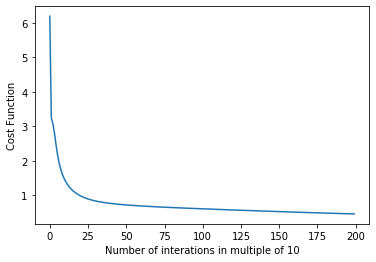

In [24]:
plt.plot(model['costs'])
plt.xlabel('Number of interations in multiple of 10')
plt.ylabel('Cost Function')

In [25]:
def predict(model , X) : #predict the value of output using parameters learnt
    params = model['params']
    cache = forward_prop(X , params)
    A2 = cache['A2']
    
    pred_y = np.argmax(A2 , axis = 0).reshape(1 , -1)
    
    return pred_y

In [26]:
train_acc = np.mean((y_train == predict(model , X_train)).astype(np.int)) * 100
test_acc = np.mean((y_test == predict(model , X_test)).astype(np.int)) * 100

print(f'Training Accuracy = {train_acc} %')
print(f'Test Accuracy = {test_acc} %')

Training Accuracy = 93.69333333333333 %
Test Accuracy = 93.78999999999999 %


The above accuracy can be improved by better tuning the hyperparameters such number of hidden units , learning rate etc.

Text(0.5, 1.0, 'Predicted Digit = 4 Actual Digit = 4')

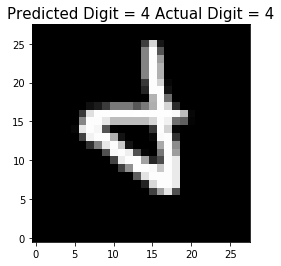

In [35]:
index = random.randint( 0 , n_x)

pred_y_test = predict(model , X_test)

plt.imshow(X_test[ : , index].reshape(img_h , -1) , cmap = 'gray' , origin='lower')
plt.title(f'Predicted Digit = {pred_y_test[0 , index]} Actual Digit = {y_test[0 , index]}' , fontsize='15')